# Visualizing NE types in PILE-NER corpus by plotting their word embeddings

In [10]:
import sys
sys.path.append("/Users/andrew/ExpertAI/MSEQA_for_NER/src/MSEQA_4_NER")
from data_handlers import data_handler_pileNER

import gensim # to use pre-trained word2vec model
import gensim.downloader as gensim_downloader

from sklearn.metrics.pairwise import cosine_similarity

import numpy as np
import pandas as pd

import json

In [11]:
path_to_ne_types_list = '../data_handlers/questions/ne_types_list.json'
with open(path_to_ne_types_list, 'r') as file:
        ne_types_list = json.load(file)
print(len(ne_types_list))
print(ne_types_list)

455
['person', 'organization', 'location', 'concept', 'product', 'variable', 'date', 'medical condition', 'object', 'technology', 'chemical', 'software', 'event', 'number', 'disease', 'attribute', 'protein', 'group', 'material', 'measurement', 'other', 'function', 'entity type', 'nationality', 'country', 'class', 'process', 'title', 'animal', 'component', 'condition', 'substance', 'food', 'city', 'activity', 'type', 'company', 'time', 'method', 'property', 'organism', 'drug', 'medical procedure', 'treatment', 'profession', 'cell type', 'anatomical structure', 'job title', 'data', 'quantity', 'sports team', 'biological process', 'data type', 'programming language', 'occupation', 'file', 'body part', 'medical treatment', 'language', 'chemical compound', 'entity', 'gene', 'state', 'law', 'action', 'website', 'library', 'facility', 'publication', 'tool', 'field of study', 'compound', 'document', 'organ', 'abbreviation', 'character', 'brand', 'device', 'operating system', 'service', 'techni

In [12]:
# downloading word2vec pre-trained model
all_pretrained_word_embeddings = gensim_downloader.load("word2vec-google-news-300")
print(type(all_pretrained_word_embeddings))

<class 'gensim.models.keyedvectors.KeyedVectors'>


In [13]:
print(f"Each word embedding is a vector of shape: {all_pretrained_word_embeddings[0].shape}")
print(f"of type {type(all_pretrained_word_embeddings)}")
print(f"each vector is of type {type(all_pretrained_word_embeddings[0])}") # access by index
# print(word_emb["apple"]) # access by word-lookup

Each word embedding is a vector of shape: (300,)
of type <class 'gensim.models.keyedvectors.KeyedVectors'>
each vector is of type <class 'numpy.ndarray'>


In [14]:
for ne in ne_types_list:
    for word in ne.split():
        if word not in all_pretrained_word_embeddings:
            print(f"\"{word}\" not in embeddings")

"of" not in embeddings
"anatomical_structure" not in embeddings
"cryptocurrency" not in embeddings
"of" not in embeddings
"biological_process" not in embeddings
"body_part" not in embeddings
"demonym" not in embeddings
"of" not in embeddings
"gpe" not in embeddings
"gene/protein" not in embeddings
"medical_condition" not in embeddings
"work_of_art" not in embeddings
"anatomicalstructure" not in embeddings
"norp" not in embeddings
"of" not in embeddings
"job_title" not in embeddings
"organisation" not in embeddings
"chemical_substance" not in embeddings
"medicalcondition" not in embeddings
"fieldterminology" not in embeddings


##### Defining a dictionary to map some NE types in words belonging to all_pretrained_word_embeddings

In [15]:
ne_mapping = {"cryptocurrency": ["crypto", "currency"], 
                "demonym": ["inhabitants", "natives"], 
                "gpe": ["geo", "political", "entity"],
                "anatomicalstructure": ["anatomical", "structure"],
                "norp": ["nationalities", "religious", "political", "group"],
                "organisation": ["organization"],
                "medicalcondition": ["medical", "condition"],
                "fieldterminology": ["field", "terminology"]
                }

In [16]:
def get_embedding_for_ne(word_emb_model, ne, ne_mapping):
    """ 
    Given a NE type return its embedding vector.
    Since a NE type may be composed of multiple words like "medical condition" we take the average of its sub-words embeddings.
    If a NE type/word is not present in word2vec embeddings we map it to some other existings words (e.g. a synonym)
    """
    ne_words = ne.split()
    if len(ne_words) == 1:
        if ne not in word_emb_model:
            # try splitting using _ or /
            # e.g work_of_art or gene/protein
            if "/" in ne:
                ne_words = ne.split("/")
            elif "_" in ne:
                ne_words = ne.split("_")
            else:    
                if ne in ne_mapping:
                    ne_words = ne_mapping[ne]
                else:
                    print(f"\"{ne}\" not in word_emb_model!")
                    return np.zeros_like(word_emb_model[0])
        else:
            return word_emb_model[ne]
            
    tot_sum = np.zeros_like(word_emb_model[0])
    n_sub_words = 0
    for sub_word in ne_words:
        if sub_word in word_emb_model:
            tot_sum += word_emb_model[sub_word]
            n_sub_words += 1
        else:
            print(f"\"{sub_word}\" not found while processing ne: \"{ne}\", will be skipped")
    average = tot_sum / n_sub_words
    return average

In [17]:
for ne in ne_types_list:
    if get_embedding_for_ne(all_pretrained_word_embeddings, ne, ne_mapping) is None:
        print(ne)

"of" not found while processing ne: "field of study", will be skipped
"of" not found while processing ne: "work of art", will be skipped
"of" not found while processing ne: "group of people", will be skipped
"of" not found while processing ne: "work_of_art", will be skipped
"of" not found while processing ne: "unit of measurement", will be skipped


In [18]:
ne_types_embeddings = np.array([get_embedding_for_ne(all_pretrained_word_embeddings, ne, ne_mapping) for ne in ne_types_list])

"of" not found while processing ne: "field of study", will be skipped
"of" not found while processing ne: "work of art", will be skipped
"of" not found while processing ne: "group of people", will be skipped
"of" not found while processing ne: "work_of_art", will be skipped
"of" not found while processing ne: "unit of measurement", will be skipped


In [19]:
print(ne_types_embeddings.shape)

(455, 300)


### Constructing KeyedVector object to store embedding for each NE type

In [22]:
from gensim.models import KeyedVectors

In [23]:
ne_embeddings_keyedvector = KeyedVectors(vector_size=ne_types_embeddings.shape[-1], count=ne_types_embeddings.shape[0])
for ne_name, ne_emb in zip(ne_types_list, ne_types_embeddings):
    ne_embeddings_keyedvector.add_vector(key=ne_name, vector=ne_emb)

In [24]:
ne_embeddings_keyedvector.key_to_index['person']
ne_embeddings_keyedvector.index_to_key[0]

'person'

In [ ]:
def retrieve_most_similar(query_words_list, all_words_embeddings_kv, my_NE_kv):
    
    # get the word embeddings for the query words
    query_emb = all_words_embeddings_kv[query_words_list] # shape: |Q| x 300
    
    # get cosine similarity between queries and my NE embeddings
    cos_sim = cosine_similarity(query_emb, my_NE_kv.vectors) # shape: |Q| x |V_r|=455

    # cos_sim = np.where(cos_sim > 0, cos_sim, 0)
    #cos_sim_thresholded = [cos_sim_row[cos_sim_row > 0.3] for cos_sim_row in cos_sim]
    #print(cos_sim_thresholded)
    #nn = [np.argsort(-cos_sim_row_t) for cos_sim_row_t in cos_sim_thresholded]

    # sort similarities in desceding orders and get indices of nearest neighbours
    nn = np.argsort(-cos_sim) # shape: |Q| x |V_r|

    #print(nn)
    # delete self-similarity, i.e. cos_sim(w,w)=1.0 
    #nn_filtered = nn[:, 1:] # remove self_similarity
    
    
    # use the indices to get the words
    nn_filtered = [[] for i in range(nn.shape[0])]
    for i, n_i in enumerate(nn): 
        for j, n_i_j in enumerate(n_i):
            if cos_sim[i,j]>0.1:
                nn_filtered[i].append(n_i_j)
    print(nn_filtered)
    nn_words = [np.array(my_NE_kv.index_to_key)[nn_f] for nn_f in nn_filtered]
    
    return nn_words

In [25]:
def retrieve_top_K_most_similar(query_words_list, all_words_embeddings_kv, my_NE_kv, top_k=10):
    
    # get the word embeddings for the query words
    query_emb = all_words_embeddings_kv[query_words_list] # shape: |Q| x 300
    
    # get cosine similarity between queries and my NE embeddings
    cos_sim = cosine_similarity(query_emb, my_NE_kv.vectors) # shape: |Q| x |V_r|=455

    # sort similarities in desceding orders and get indices of nearest neighbours
    nn = np.argsort(-cos_sim) # shape: |Q| x |V_r|

    # delete self-similarity, i.e. cos_sim(w,w)=1.0 
    nn_filtered = nn[:, 1:] # remove self_similarity
    
    nn_words = np.array(my_NE_kv.index_to_key)[nn_filtered][:, :top_k]
    
    return nn_words

In [32]:
queries = ["person", "organization", "location", "date", "time", "miscellaneous"]
top_k = 15
res = retrieve_top_K_most_similar(queries, all_pretrained_word_embeddings, ne_embeddings_keyedvector, top_k=top_k)

for query_word, most_similar_to_q in zip(queries, res):
    print(query_word)
    print(most_similar_to_q)
    print("-------------------")

person
['people' 'group of people' 'entity type' 'entity type not specified'
 'patient group' 'patient' 'creature' 'athlete' 'user' 'entity' 'type'
 'user interface element' 'living organism' 'item' 'condition']
-------------------
organization
['organisation' 'governmental organization' 'group' 'entity'
 'social group' 'educational institution' 'group of people'
 'government agency' 'org' 'patient group' 'entity type' 'team'
 'religious group' 'political group' 'age group']
-------------------
location
['geographic location' 'venue' 'facility' 'route' 'store' 'data structure'
 'neighborhood' 'place' 'restaurant' 'date' 'data type' 'size'
 'medical facility' 'name' 'data format']
-------------------
date
['set' 'subject' 'location' 'year' 'file name' 'geographic location'
 'time' 'month' 'time period' 'venue' 'entity type not specified'
 'duration' 'name' 'specific' 'information']
-------------------
time
['time period' 'year' 'month' 'season' 'place' 'duration' 'date' 'money'
 'term' 

### Plotting the top_k NE types (among our list of NE types) most similar to each query word

In [20]:
from sklearn.decomposition import PCA

In [21]:
all_res_words = res.flatten()
res_word_emb = ne_embeddings_keyedvector[all_res_words]
pca = PCA(n_components=3) #Perform 3d-PCA
word_emb_pca = pca.fit_transform(res_word_emb)

In [22]:
pca_df = pd.DataFrame(word_emb_pca, columns=["pca_x", "pca_y", "pca_z"])

pca_df["word"] = res.flatten()

labels = np.array([queries]).repeat(top_k)
pca_df["query"] = labels

print(pca_df.head())

      pca_x     pca_y     pca_z                       word   query
0  0.058417 -0.530820  0.133391                     people  person
1  0.221345 -0.687288  0.243515            group of people  person
2  0.984710  0.073084 -0.460458                entity type  person
3  0.421284  0.143852 -0.533350  entity type not specified  person
4  0.244947 -0.643533 -0.122138              patient group  person


In [23]:
import plotly.express as px
px.scatter_3d(pca_df, x='pca_x', y='pca_y', z='pca_z', color="query", text="word", opacity=0.7, title="3d-PCA representation of word embeddings")

## 2D

In [26]:
all_res_words = res.flatten()
res_word_emb = ne_embeddings_keyedvector[all_res_words]
pca = PCA(n_components=2) #Perform 2d-PCA
word_emb_pca = pca.fit_transform(res_word_emb)

pca_df = pd.DataFrame(word_emb_pca, columns=["pca_x", "pca_y"])

pca_df["word"] = res.flatten()

labels = np.array([queries]).repeat(top_k)
pca_df["query"] = labels

print(pca_df.head())

import plotly.express as px
px.scatter(pca_df, x='pca_x', y='pca_y', color="query", text="word", opacity=0.7, title="2d-PCA representation of word embeddings")

      pca_x     pca_y                       word   query
0  0.058417 -0.530820                     people  person
1  0.221345 -0.687288            group of people  person
2  0.984710  0.073084                entity type  person
3  0.421284  0.143852  entity type not specified  person
4  0.244947 -0.643533              patient group  person


### 3D plotting of all NE types

In [27]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

In [28]:
pca = PCA(n_components=3) #Perform 3d-PCA
word_emb_3d = pca.fit_transform(ne_types_embeddings)

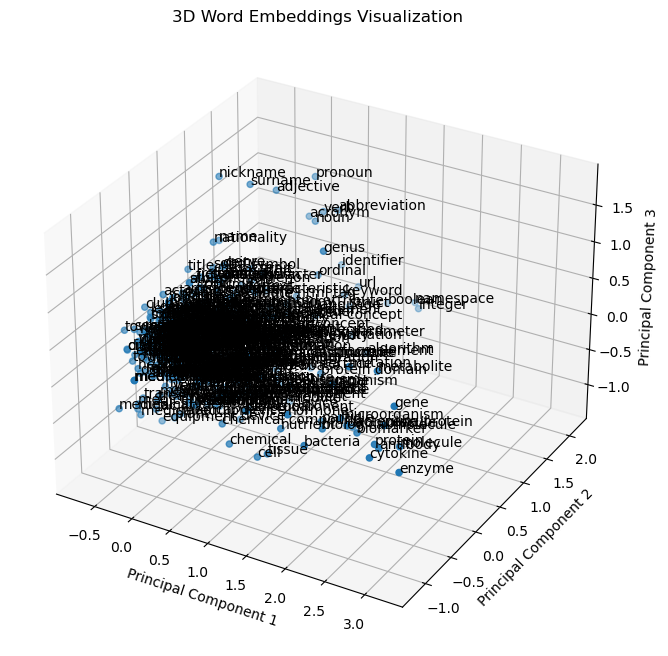

In [29]:
# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
ax.scatter(word_emb_3d[:, 0], word_emb_3d[:, 1], word_emb_3d[:, 2])

# Annotate points with word labels (adjust labels accordingly)
for i, word in enumerate(ne_types_list):
    ax.text(word_emb_3d[i, 0], word_emb_3d[i, 1], word_emb_3d[i, 2], word)

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D Word Embeddings Visualization')

plt.show()

In [30]:
import plotly.express as px

# Create a DataFrame with the 3D embeddings and word labels
data = {'x': word_emb_3d[:, 0], 'y': word_emb_3d[:, 1], 'z': word_emb_3d[:, 2], 'word': ne_types_list}
df = pd.DataFrame(data)

# Create a 3D scatter plot using Plotly Express
fig = px.scatter_3d(df, x='x', y='y', z='z', text='word', title='3D Word Embeddings Visualization')

# Show the plot
fig.show()

In [31]:
pca = PCA(n_components=2) #Perform 2d-PCA
word_emb_2d = pca.fit_transform(ne_types_embeddings)

import plotly.express as px
# Create a DataFrame with the 2D embeddings and word labels
data = {'x': word_emb_2d[:, 0], 'y': word_emb_2d[:, 1], 'word': ne_types_list}
df = pd.DataFrame(data)

# Create 2D scatter plot using Plotly Express
fig = px.scatter(df, x='x', y='y', text='word', title='2D Word Embeddings Visualization')

fig.show()

# Hierarchical clustering dendogram

In [32]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

In [33]:
model = AgglomerativeClustering(n_clusters=None, # end when 1 cluster
                                metric='cosine', # cosine is 1-cosine_similarity which means is a measure of dissimilarity, distance measure between [0,2]
                                linkage='average',
                                distance_threshold=0)

In [34]:
print(ne_types_embeddings.shape)

(455, 300)


In [35]:
print(ne_types_list)

['person', 'organization', 'location', 'concept', 'product', 'variable', 'date', 'medical condition', 'object', 'technology', 'chemical', 'software', 'event', 'number', 'disease', 'attribute', 'protein', 'group', 'material', 'measurement', 'other', 'function', 'entity type', 'nationality', 'country', 'class', 'process', 'title', 'animal', 'component', 'condition', 'substance', 'food', 'city', 'activity', 'type', 'company', 'time', 'method', 'property', 'organism', 'drug', 'medical procedure', 'treatment', 'profession', 'cell type', 'anatomical structure', 'job title', 'data', 'quantity', 'sports team', 'biological process', 'data type', 'programming language', 'occupation', 'file', 'body part', 'medical treatment', 'language', 'chemical compound', 'entity', 'gene', 'state', 'law', 'action', 'website', 'library', 'facility', 'publication', 'tool', 'field of study', 'compound', 'document', 'organ', 'abbreviation', 'character', 'brand', 'device', 'operating system', 'service', 'technique'

In [36]:
labels = model.fit_predict(ne_types_embeddings[:, :])

In [37]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Define a custom leaf label function
    def label_leaf_custom(id):
        # id corresponds to cluster index
        if id < n_samples:
            # Singleton leaf, use the label from ne_types_list
            return ne_types_list[id]
        else:
            # Non-singleton cluster
            return f"Cluster {id}, Count: {int(counts[id - n_samples])}"

    plt.figure(figsize=(10, 50))

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, orientation='right', leaf_label_func=label_leaf_custom, leaf_rotation=0, **kwargs)

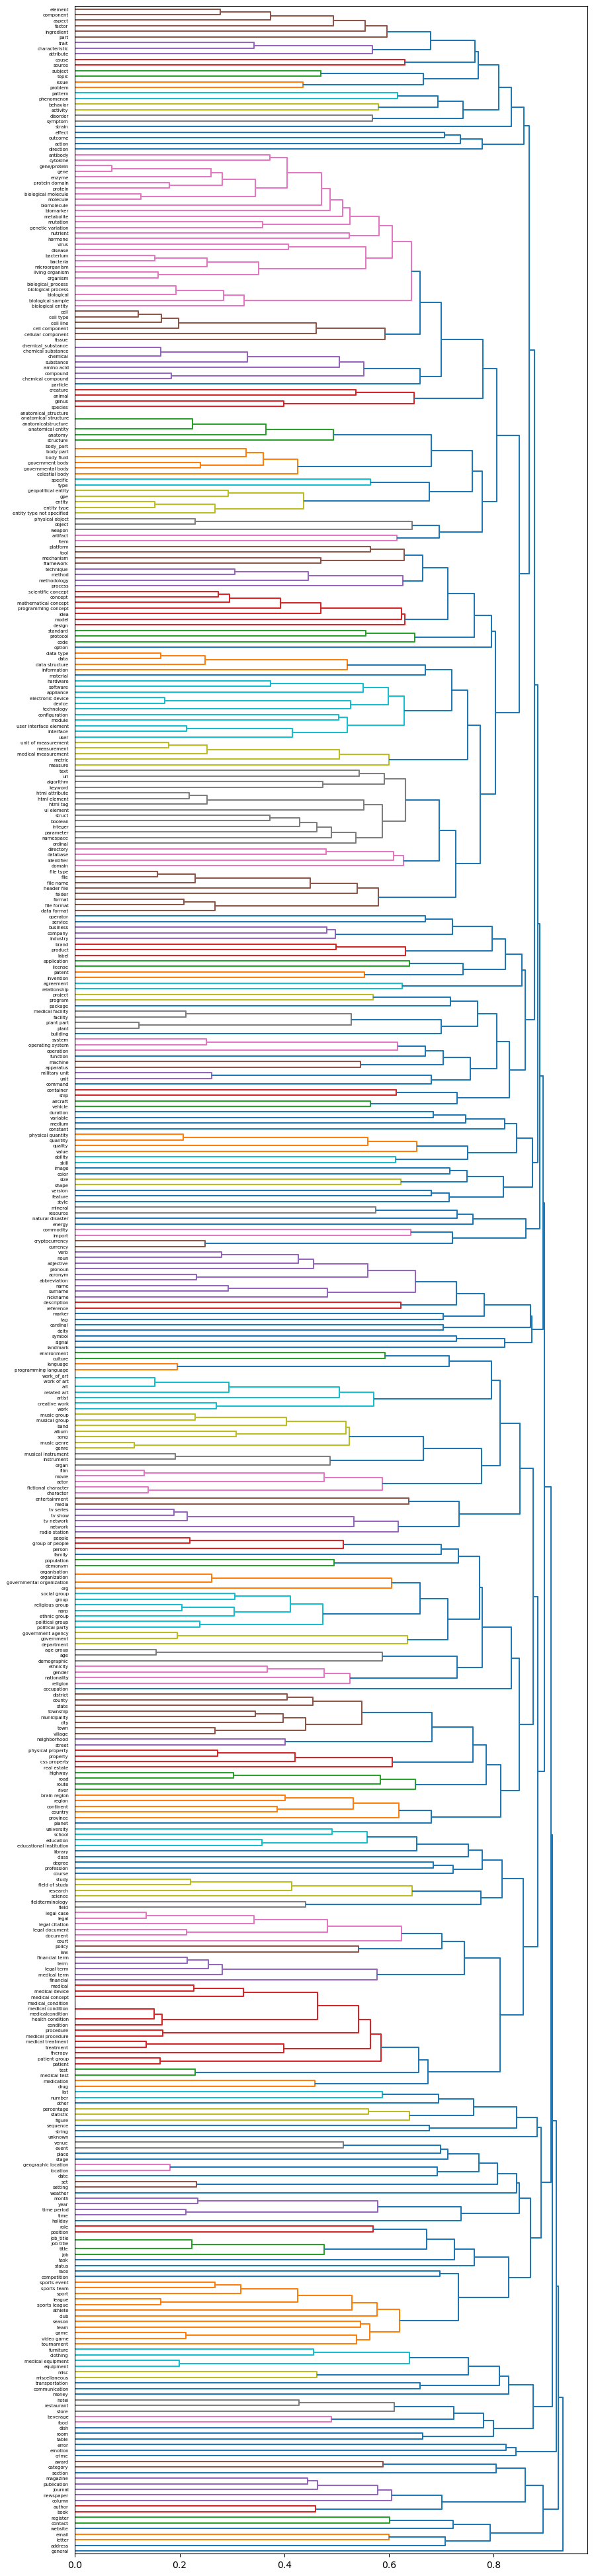

In [38]:
plot_dendrogram(model) # , truncate_mode="level", p=5

In [33]:
new_ne_type_list = {
    "misc": None,
    "miscellaneous": None,
    "other": None,
    "unknown": None,
    "general": None,
    "entity type not specified": None,
    "entity type": None,
    "entity": None,
    "text": None,
    "import": None,
    
    "bacteria": "bacterium",
    "biological": "biological entity",
    "cell": "cell type",
    "cellular component": "cell component",
    "governmental body": "government body",
    "movie": "film",
    "work": "work of art",
    "musical group": "music group",
    "org": "organization",

    "anatomical_structure": "anatomical structure",
    "anatomicalstructure": "anatomical structure",
    "biological_process": "biological process",
    "body_part": "body part",
    "gpe": "geopolitical entity",
    "gene/protein": "gene",
    "work_of_art": "work of art",
    "job_title": "job title",
    "organisation": "organization",
    "chemical_substance": "chemical substance",
    "medical_condition": "medical condition",
    "medicalcondition": "medical condition",

    "fieldterminology": None,
    "cryptocurrency": "cryptocurrency",
    "demonym": "demonym",
    "norp": "norp"
}

In [34]:
# checking all key, values are in NE types list
for k,v in new_ne_type_list.items():
    if k not in ne_types_list:
        print(k)
    if v is not None and v not in ne_types_list:
        print(v)